In [2]:
#imports

import torch
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch.nn as nn
import time
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix


In [ ]:
def create_dataset(folder_path):
    my_list = []
    for category in ['NORMAL', 'PNEUMONIA', 'UNKNOWN', 'TUBERCULOSIS']:
        category_path = os.path.join(folder_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)

            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

dataset_dir = "/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data/"
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

train_df = create_dataset(train_dir)
val_df = create_dataset(val_dir)
test_df = create_dataset(test_dir)

train_df['label'] = train_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1, 'UNKNOWN': 2 , 'TUBERCULOSIS': 3})
val_df['label'] = val_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1, 'UNKNOWN': 2, 'TUBERCULOSIS': 3})
test_df['label'] = test_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1, 'UNKNOWN': 2, 'TUBERCULOSIS': 3})

print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}, Test set size: {len(test_df)}")


Train set size: 13028, Validation set size: 761, Test set size: 1527


In [ ]:
def count_categories(df, dataset_name):
    category_counts = df['label'].value_counts()
    print(f"{dataset_name} set:")
    print(f"  NORMAL: {category_counts.get(0, 0)}")  # NORMAL = 0
    print(f"  PNEUMONIA: {category_counts.get(1, 0)}")  # PNEUMONIA = 1
    print(f"  UNKNOWN: {category_counts.get(2, 0)}")  # UNKNOWN = 2 (added the UNKNOWN category)
    print(f"  TUBERCULOSIS: {category_counts.get(3, 0)}")  # TUBERCULOSIS = 3

print("Image Counts per Category:")
count_categories(train_df, "Train")
count_categories(val_df, "Validation")
count_categories(test_df, "Test")

Image Counts per Category:
Train set:
  NORMAL: 4667
  PNEUMONIA: 3633
  UNKNOWN: 1155
  TUBERCULOSIS: 3573
Validation set:
  NORMAL: 274
  PNEUMONIA: 213
  UNKNOWN: 67
  TUBERCULOSIS: 207
Test set:
  NORMAL: 548
  PNEUMONIA: 427
  UNKNOWN: 135
  TUBERCULOSIS: 417


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Image path
        label = self.dataframe.iloc[idx, 1]     # Image label (NORMAL, PNEUMONIA, UNKNOWN)
        img = Image.open(img_path).convert('RGB')  # Convert the image to RGB if not already

        if self.transform:
            img = self.transform(img)

        return img, label



train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


val_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

train_dataset_resnet = ImageDataset(train_df, transform=train_transform_resnet)
val_dataset_resnet = ImageDataset(val_df, transform=val_transform_resnet)

batch_size = 32

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader_resnet)}")
print(f"Validation dataset size: {len(val_loader_resnet)}")



Training dataset size: 408
Validation dataset size: 24


In [ ]:

def prepare_model_for_multigpu(model):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            model = nn.DataParallel(model)
        model = model.to(device)
    else:
        print("CUDA is not available. Using CPU.")
        device = torch.device("cpu")  
        model = model.to(device)
    
    return model

In [ ]:
def train_model_with_history_and_tensorboard(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda'):


    writer = SummaryWriter(log_dir='tensorboard_logs')

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    if os.path.exists('model/model_29.pt'):
        model.load_state_dict(torch.load('model/model_29.pt', map_location=device))
        print("Model weights loaded successfully.")
    else:
        print("No pre-trained weights found, starting from scratch.")
    
    model_dir = 'model'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    for epoch in range(num_epochs):
        start_epoch_time = time.time() 

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        start_val_time = time.time()

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_val_time = time.time()
        validation_time = end_val_time - start_val_time

        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time

        print(f"Epoch [{epoch+1}/{num_epochs}] "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
                f"Epoch Time: {epoch_time:.2f}s | Validation Time: {validation_time:.2f}s")

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
        writer.add_scalar('Time/Epoch', epoch_time, epoch)
        writer.add_scalar('Time/Validation', validation_time, epoch)

        if epoch == 24 :
            torch.save(model.state_dict(), f'{model_dir}/model_{epoch}.pt')
            

    writer.close()

    return train_losses, val_losses, train_accuracies, val_accuracies


criterion = nn.CrossEntropyLoss()


In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 4) 
resnet18 = prepare_model_for_multigpu(resnet18)  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [ ]:
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.0001)

print("Training Pretrained ResNet-18 Model...")
train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet = train_model_with_history_and_tensorboard(
    resnet18, train_loader_resnet, val_loader_resnet, criterion, optimizer_resnet, num_epochs=1
)


Training Pretrained ResNet-18 Model...
No pre-trained weights found, starting from scratch.
Epoch [1/1] Train Loss: 0.1706, Train Acc: 93.57% | Val Loss: 0.0903, Val Acc: 96.85% | Epoch Time: 363.40s | Validation Time: 18.65s


<ipython-input-10-51a6a2b8180f>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/pneumonia-and-tuberculosis-with-normal-and-

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9853    0.9799    0.9826       548
   PNEUMONIA     0.9791    0.9883    0.9837       427
     UNKNOWN     1.0000    1.0000    1.0000       135
TUBERCULOSIS     0.9952    0.9928    0.9940       417

    accuracy                         0.9876      1527
   macro avg     0.9899    0.9903    0.9901      1527
weighted avg     0.9876    0.9876    0.9876      1527



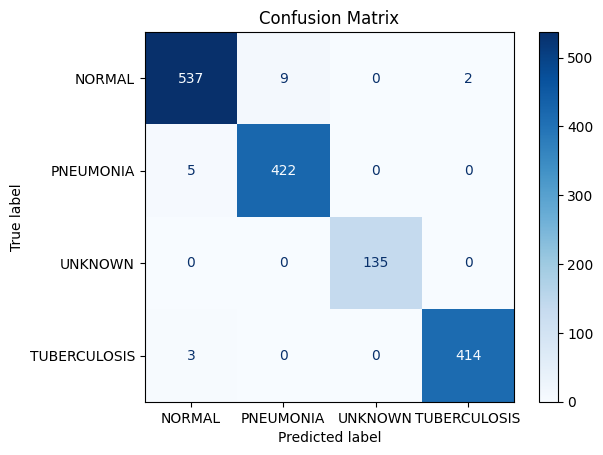

Accuracy: 98.7557%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  

model.load_state_dict(torch.load('/kaggle/input/pneumonia-and-tuberculosis-with-normal-and-non-x-ray/pytorch/default/1/model_24.pt'))
model.eval()
model.to(device)

test_dir = "/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data/test"
categories = ["NORMAL", "PNEUMONIA", "UNKNOWN", "TUBERCULOSIS"]

y_true = [] 
y_pred = [] 

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transformations(image)
    image = image.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        predicted_label = output.argmax(dim=1).item()
    return predicted_label

for label, category in enumerate(categories):
    category_dir = os.path.join(test_dir, category)
    if not os.path.exists(category_dir):  
        print(f"Warning: Directory {category_dir} does not exist. Skipping...")
        continue

    for image_name in os.listdir(category_dir):
        if image_name.lower().endswith(('png', 'jpg', 'jpeg', '.bmp')):
            image_path = os.path.join(category_dir, image_name)
            y_true.append(label) 
            y_pred.append(predict_image(image_path))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(
    y_true, 
    y_pred, 
    target_names=categories, 
    digits=4 
)
print("Classification Report:")
print(report)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


accuracy = np.mean(y_true == y_pred) * 100
print(f"Accuracy: {accuracy:.4f}%")
